# Stable Diffusion simplificado com CIFAR-10
Este notebook demonstra, de ponta a ponta, como montar um protótipo de pipeline de difusão usando PyTorch. 
1. Checamos dependências e importamos bibliotecas essenciais (Torch, Torchvision, matplotlib e tqdm).
2. Preparamos o dataset CIFAR-10 com normalização apropriada e DataLoader embaralhado.
3. Definimos um UNet minimalista, responsável por remover ruído das imagens.
4. Implementamos as etapas de difusão (adicionar ruído e treinar o modelo para removê-lo).
5. Visualizamos resultados comparando imagem original, ruidosa e reconstruída.

Use-o como base para experimentar variações de arquiteturas ou hiperparâmetros antes de migrar para modelos de difusão mais sofisticados.

In [1]:
# Parte 1: Configuração do ambiente e instalação de bibliotecas
# !pip install torch torchvision tqdm


In [2]:
# Parte 2: Importação das bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


### Preparação do CIFAR-10
Baixamos o conjunto de treino do CIFAR-10 diretamente via `torchvision.datasets`, aplicando transformações que convertem as imagens para tensores e normalizam os valores em torno de 0. Essa etapa garante que o ruído adicionado posteriormente tenha magnitude comparável aos dados e que o treinamento seja estável. O DataLoader embaralhado fornece mini-batches de 64 imagens para cada época.

In [3]:

# Parte 3: Preparação do conjunto de dados CIFAR-10
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)



100%|██████████| 170M/170M [00:39<00:00, 4.29MB/s] 


### Arquitetura utilizada
Implementamos um UNet bem reduzido apenas para fins didáticos. Ele contém poucas camadas de convolução tanto no encoder quanto no decoder, suficientes para aprender a reconstruir padrões simples do CIFAR-10. Em experimentos reais de difusão, a arquitetura seria muito mais profunda e incluiria *skip connections* elaboradas para manter detalhes de alta frequência.

In [4]:
# Parte 4: Definição da arquitetura do modelo (UNet simplificado)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = UNet()



### Hiperparâmetros de treinamento
Aqui definimos a função de perda (`MSELoss`), o otimizador (`Adam`) e o número de épocas. Ajuste esses valores conforme o hardware disponível: mais épocas e taxas de aprendizado menores tendem a produzir resultados melhores, porém com maior custo computacional.

In [5]:
# Parte 5: Configuração dos parâmetros de treinamento
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10



### Funções de difusão
`add_noise` representa o processo *forward* (difusão): adicionamos ruído gaussiano às imagens normalizadas. `remove_noise` simboliza o processo *reverse*, chamando o modelo para prever uma versão limpa. Esses passos mimetizam, em pequena escala, o comportamento de modelos de difusão modernos que aprendem a inverter ruídos Gaussianos passo a passo.

In [7]:
# Parte 6: Implementação do processo de difusão (forward e reverse process)
def add_noise(images, noise_factor=0.5):
    noise = torch.randn_like(images) * noise_factor
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

def remove_noise(noisy_images):
    return model(noisy_images)


### Loop de treinamento
Durante cada época, adicionamos ruído ao batch, pedimos ao modelo para removê-lo e otimizamos a perda entre a imagem denoised e a original. O `tqdm` oferece feedback do progresso. Fique atento ao uso de GPU (`images = images.to(device)`) caso adapte o notebook para treinamento acelerado.

In [8]:
# Parte 7: Execução do treinamento e visualização dos resultados
for epoch in range(epochs):
    for images, _ in tqdm(train_loader):
        noisy_images = add_noise(images)
        denoised_images = remove_noise(noisy_images)

        loss = criterion(denoised_images, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')



  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.0281


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.0246


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.0278


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.0221


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.0242


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.0231


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.0231


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.0233


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.0228


  0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.0241


### Visualização
A função `visualize_results` facilita inspecionar qualitativamente o desempenho: exibimos uma imagem original, sua versão degradada e a saída reconstruída. Utilize essa etapa para validar se o modelo está realmente aprendendo padrões úteis antes de seguir para grids maiores ou salvar checkpoints.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.75343364..0.95023686].


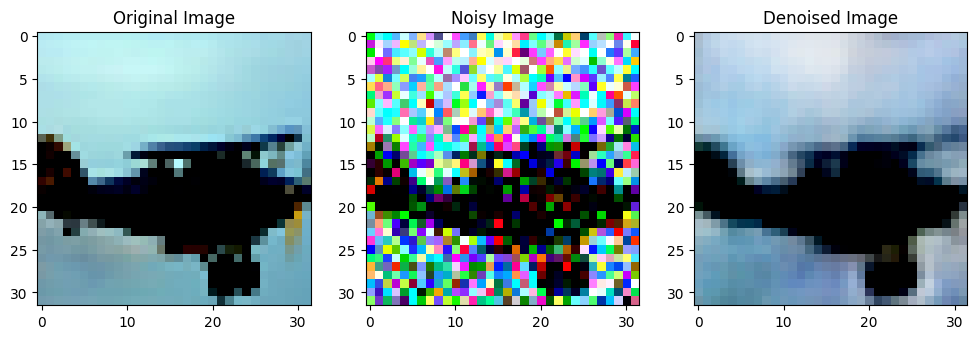

In [9]:
# Parte 8: Gerar e visualizar imagens
def visualize_results(images, noisy_images, denoised_images):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(images[0].permute(1, 2, 0).cpu().numpy())
    axes[0].set_title("Original Image")
    axes[1].imshow(noisy_images[0].permute(1, 2, 0).cpu().numpy())
    axes[1].set_title("Noisy Image")
    axes[2].imshow(denoised_images[0].detach().permute(1, 2, 0).cpu().numpy())
    axes[2].set_title("Denoised Image")
    plt.show()

# Teste final: Visualização de exemplos
dataiter = iter(train_loader)
images, _ = next(dataiter)  # Corrigido
noisy_images = add_noise(images)
denoised_images = remove_noise(noisy_images)

visualize_results(images, noisy_images, denoised_images)


## Próximos passos
- Experimente diferentes níveis de ruído (`noise_factor`) e veja como isso impacta a capacidade do modelo.
- Amplie o UNet com mais camadas ou *skip connections* completas para aproximar-se de difusores reais.
- Adicione checkpoints e métricas (FID/PSNR) para acompanhar a evolução de forma quantitativa.

Essa base já permite explorar o fluxo de difusão com datasets pequenos; evolua gradualmente até chegar em modelos pré-treinados como Stable Diffusion.